PDE Equation:  $$\frac{\partial u}{\partial t} = D (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2})$$

BC and IC:  $$u=\sin(\pi x) \cdot e^{-y} \cdot e^{-t}$$

In [ ]:
! pip install deepxde
import deepxde as dde
import numpy as np
geom= dde.geometry.geometry_2d.Rectangle([-1,-1],[1,1])
timedomain=dde.geometry.TimeDomain(0,1)
geomtime=dde.geometry.GeometryXTime(geom,timedomain)


## Defining PDE equation

In [ ]:
from deepxde.backend import tf
def pde(X, u):
    du_X = tf.gradients(u,X)[0]
    du_x,du_y,du_t=du_X[:,0:1],du_X[:,1:2],du_X[:,2:3]
    du_xx=tf.gradients(du_x,X)[0][:,0:1]
    du_yy=tf.gradients(du_y,X)[0][:,1:2]

    return du_t - 0.5 * (du_xx+du_yy)

## Boundary Condition And Initial Condition

In [ ]:
def func(x):
     return np.sin(np.pi*x[:,0:1])*np.exp(-x[:,1:2])*np.exp(-x[:,2:3])

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)


## Training Data


In [ ]:
data= dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution = func,
    num_test =1000,
)


# Initializer And Optimizer

In [ ]:
initializer = "Glorot uniform"
Optimizer = "adam"

## Neural Network Structure

In [ ]:
layer_size =[3]+[32]*4+[1]
activation = "tanh"
net = dde.maps.FNN(layer_size,activation,initializer)


## Compile The Model And Train

In [ ]:
import time
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
t1 = time.time()

losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.082709 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.057050 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.00e-01, 5.69e-01, 1.13e+00]    [2.15e-01, 5.69e-01, 1.13e+00]    []  
1000      [6.83e-03, 9.01e-03, 7.81e-03]    [4.18e-03, 9.01e-03, 7.81e-03]    []  
2000      [1.92e-03, 2.71e-03, 1.45e-03]    [1.45e-03, 2.71e-03, 1.45e-03]    []  
3000      [1.13e-03, 1.78e-03, 6.69e-04]    [9.91e-04, 1.78e-03, 6.69e-04]    []  
4000      [8.36e-04, 1.40e-03, 5.25e-04]    [7.03e-04, 1.40e-03, 5.25e-04]    []  
5000      [6.39e-04, 1.16e-03, 4.71e-04]    [4.97e-04, 1.16e-03, 4.71e-04]    []  
6000      [5.27e-04, 9.87e-04, 4.44e-04]    [3.79e-04, 9.87e-04, 4.44e-04]    []  
7000      [4.56e-04, 8.59e-04, 4.14e-04]    [3.08e-04, 8.59e-04, 4.14e-04]    []  
8000      [4.15e-04, 7.61e-04, 3.80e-04]    [2.66e-04, 7.61e-04, 3.80e-04]    []  
9000      [5.27e-04, 7.04e-04, 3.61e-04]    [3.21e-04, 7.04e-04, 3.61e-04]    []  
10000     [3.62e-04, 6.08e-04, 3.1

### Results From NN

In [ ]:
a = 0.4  # Thermal diffusivity
# L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def heat_eq_exact_solution(x, y, t):
    norms = np.linalg.norm(np.vstack((x, y)), axis=0)  # Calculate norm along columns (axis=0)
    return 1 / (4 * np.pi * a * t) * np.exp(-norms**2 / (4 * a * t))

def gen_exact_solution():

    # Number of points in each dimension:
    x_dim, y_dim, t_dim = (256, 256, 201)

    # Bounds of 'x' and 't':
    x_min,y_min, t_min = (0,0,0)
    x_max,y_max, t_max = (1,1,1)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    y = np.linspace(y_min, y_max, num=y_dim).reshape(y_dim, 1)
    usol = np.zeros((x_dim, y_dim, t_dim)).reshape(x_dim,y_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    x, y, t = np.meshgrid(np.linspace(x_min, x_max, num=x_dim), np.linspace(y_min, y_max, num=y_dim), np.linspace(t_min, t_max, num=t_dim))
    usol = heat_eq_exact_solution(x, y, t)


    # Save solution:
    np.savez("heat_eq_data", x=x, y=y, t=t, usol=usol)


In [ ]:

gen_exact_solution()

<ipython-input-10-a686ab251f85>:7: RuntimeWarning: divide by zero encountered in divide
  return 1 / (4 * np.pi * a * t) * np.exp(-norms**2 / (4 * a * t))
<ipython-input-10-a686ab251f85>:7: RuntimeWarning: invalid value encountered in multiply
  return 1 / (4 * np.pi * a * t) * np.exp(-norms**2 / (4 * a * t))


Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


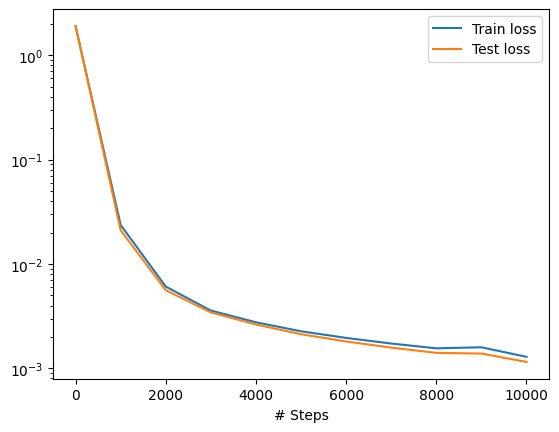

In [ ]:
# def gen_testdata():
#     """Import and preprocess the dataset with the exact solution."""
#     # Load the data:
#     data = np.load("heat_eq_data.npz")
#     # Obtain the values for t, x, and the excat solution:
#     t, x, y, exact = data["t"], data["x"], data["y"], data["usol"].T
#     # Process the data and flatten it out (like labels and features):
#     xx,yy, tt = np.meshgrid(x,y,t)
#     X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
#     u = exact.flatten()[:, None]
#     return X, u
def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the exact solution:
    t, x, y, exact = data["t"], data["x"], data["y"], data["usol"].T

    # Flatten the meshgrid without creating individual meshgrids for each variable
    X = np.column_stack((x.flatten(), y.flatten(), t.flatten()))
    u = exact.flatten()[:, None]

    return X, u
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, u_true = gen_testdata()
u_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_true, u_pred))
np.savetxt("test.dat", np.hstack((X, u_true, u_pred)))